<a href="https://colab.research.google.com/github/umairiqbal78/Deep-learning-Projects/blob/main/Toxic_comment_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score # auc means area under curve metric is given to us which is helpful for classification problem

In [2]:

from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100 #size of each word vector
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10


In [5]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/MyDrive/Glove_embedding/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("/content/drive/MyDrive/toxic_comments_udemy/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
len(targets)


Loading in comments...


159571

In [7]:

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [8]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))


max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

# exit()

Found 210337 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE: 
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [13]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [14]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [15]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
998/998 [==============================] - 104s 104ms/step - loss: 0.0842 - accuracy: 0.9783 - val_loss: 0.0731 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0674 - accuracy: 0.9930 - val_loss: 0.0687 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 103s 104ms/step - loss: 0.0635 - accuracy: 0.9939 - val_loss: 0.0667 - val_accuracy: 0.9938
Epoch 4/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0603 - accuracy: 0.9937 - val_loss: 0.0739 - val_accuracy: 0.9930
Epoch 5/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0579 - accuracy: 0.9939 - val_loss: 0.0718 - val_accuracy: 0.9913
Epoch 6/10
998/998 [==============================] - 102s 102ms/step - loss: 0.0559 - accuracy: 0.9936 - val_loss: 0.0725 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 103s 103ms/step - loss: 0.0543 - accuracy: 0.9939 - 

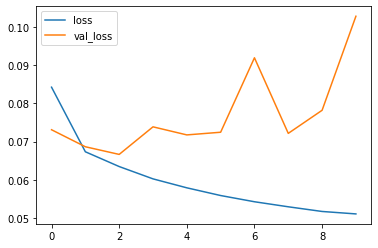

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

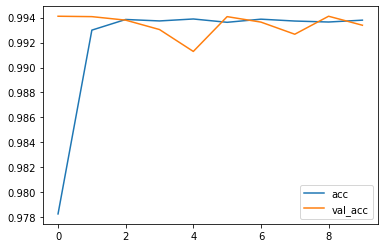

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [18]:
# plot the mean AUC over each label
p = model.predict(data)
print(p)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

[[3.40265036e-03 3.08193332e-11 2.48253345e-04 1.32007905e-10
  3.88601075e-05 1.55137784e-07]
 [3.60727310e-04 3.50339956e-13 1.30930985e-05 4.22358763e-12
  5.36959578e-06 8.55418580e-09]
 [4.77442145e-03 1.59391833e-09 2.81542540e-04 3.81643659e-08
  1.96188688e-04 1.47800824e-06]
 ...
 [3.79901597e-18 0.00000000e+00 3.38084922e-33 0.00000000e+00
  7.67694330e-34 0.00000000e+00]
 [1.97216868e-03 6.05312134e-10 1.55627728e-04 6.17348883e-09
  8.74849575e-05 5.97225721e-07]
 [8.48607421e-02 1.03776038e-05 1.02272332e-02 6.55544573e-05
  8.51169229e-03 2.11507082e-04]]
0.9741178504070708


In [25]:
import pickle

modelStoragePath = "/content/drive/MyDrive/toxic_comments_udemy"

def saveData(model, r , iteration):
    modelFile = modelStoragePath + "model_toxic_comments_model" + str(iteration).strip() + ".h5"
    r File = modelStoragePath + "_History_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model.save(modelFile)
    #saving r  file too
    with open(historyFile, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return modelFile, r File

import tensorflow.keras.models
def loadData(iteration):
    modelFile = modelStoragePath + "model_toxic_comments_model" + str(iteration).strip() + ".h5"
    r File = modelStoragePath + "_History_toxic_comments_model" + str(iteration).strip() + ".pkle"
    model = models.load_model(modelFile)
    with open(historyFile, 'rb') as file_pi:
        r  = pickle.load(file_pi)
    return model,  r

In [27]:
print(type(r))
modelFile, rFile = saveData(model, r, iteration=1)
print(modelFile, rFile, "Saved")

<class 'tensorflow.python.keras.callbacks.History'>
/content/drive/MyDrive/toxic_comments_udemymodel_toxic_comments_model1.h5 /content/drive/MyDrive/toxic_comments_udemy_History_toxic_comments_model1.pkle Saved
